In [1]:
#import packages internal and external
import tests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import pandas as pd
import datasetBuilder
import tools
import scipy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rfc
import sklearn.base
import pickle
import copy
import tests
from sklearn.metrics import roc_auc_score as auc
import os
import plotAndOrderResults
import datasetBuilder

In [2]:
a=np.array([0.02,0.02,0.04])
print(a[2]/a[1])
a=a**2
print(a[2]/a[1])
a=np.array([0.02,0.02,0.04])
a=a**0.25
print(a[2]/a[1])


2.0
4.0
1.189207115002721


In [3]:
#Set path variables where we want to save created datasets, intermediate outputs, etc
#If you want to run this on your own computer, obviously you should update the path

outputs_path='/Users/jonahpoczobutt/projects/specsim_res/testy'
os.mkdir(outputs_path)


nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14_highres.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps_highres.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_highres.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_highres.pkl'

#Set the query and target dbs
#these can be different or the same
query = metlin
target = nist14

#This variable toggles whether we do a full run of the notebook, or if we read in variables created in a previous run
fullRun=True

#create directories for results
if fullRun:
    
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/fullSearchMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/quantileDfs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/modelDatasets')
    os.mkdir(f'{outputs_path}/intermediateOutputs/models')
    os.mkdir(f'{outputs_path}/fig1')
    os.mkdir(f'{outputs_path}/fig2')
    os.mkdir(f'{outputs_path}/fig3')
    os.mkdir(f'{outputs_path}/fig4')
    os.mkdir(f'{outputs_path}/fig5')


Preprocessing: Creating Target and Matches DFs


In [4]:
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    #this method is in place
    np.random.shuffle(all_bases)

    first_bases = all_bases[:int(len(all_bases)*0.6)]
    second_bases = all_bases[int(len(all_bases)*0.6):int(len(all_bases)*0.7)]
    third_bases = all_bases[int(len(all_bases)*0.7):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],second_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    del(second_query_)

    third_query_ = query_[np.isin(query_['inchi_base'],third_bases)]
    third_query_.reset_index(inplace=True)
    third_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    del(third_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/second_bases.npy',second_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/third_bases.npy',third_bases)
    del(first_bases)
    del(second_bases)
    del(third_bases)
    del(all_bases)


Figure 1: Global Performance of Individual Metrics/Weighting Schemes

In [5]:
#these are the ppm windows that we want to test
ppm_windows = [10]

#this is the size of the sample we take from the full target
size=int(5e3)

#this is the maximum number of matches we allow for each query, based on the precursor window
max_matches=20

#adduct match
adduct_match=False

#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05]
centroid_tolerance_types=['da']
powers=[0.25,'orig','normalent']
sim_methods=None

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload queries and target for individual comparison
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    #shuffle query to ensure random subset
    query_.sample(frac=1)

    for i in ppm_windows:

        matches = datasetBuilder.create_matches_df_new(query_,target_,i,max_matches,size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')

        #comparison on large sample
        tests.create_variable_comparisons(
                                noise_threshes=noise_threshes,
                                centroid_threshes=centroid_tolerance_vals,
                                centroid_types=centroid_tolerance_types,
                                powers=powers,
                                sim_methods=sim_methods,
                                matches=matches,
                                outpath = f'{outputs_path}/fig1/{i}_ppm.csv',
                                )

error on max_jensenshannon


Figure 2: Assessing Metric Stability in Smaller Samples

In [6]:
#this is the size of the sample we take from the full target
size=5e2

#this is the number of times we want to take a sample of the above size
trials=10

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload target
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    for i in range(trials):

        os.mkdir(f'{outputs_path}/fig2/{i}')
        
        for j in ppm_windows:

            #create matches after shuffling query
            query_ = query_.sample(frac=1)
            matches = datasetBuilder.create_matches_df_new(query_,target_,j,max_matches,size, adduct_match)

            #comparison on small sample
            tests.create_variable_comparisons(
                                    noise_threshes=noise_threshes,
                                    centroid_threshes=centroid_tolerance_vals,
                                    centroid_types=centroid_tolerance_types,
                                    powers=powers,
                                    sim_methods=sim_methods,
                                    matches=matches,
                                    outpath = f'{outputs_path}/fig2/{i}/{j}_ppm.csv'
                                    )

Figures 1 and 2

Top Metrics for 10_ppm.csv by AUC
             Metric       AUC            Vec Settings
279      lorentzian  0.755548  0.01_0.05_da_normalent
130      lorentzian  0.755337       0.01_0.05_da_None
55       lorentzian  0.752078       0.01_0.05_da_0.25
247         entropy  0.744110  0.01_0.05_da_normalent
239   jensenshannon  0.743902  0.01_0.05_da_normalent
288        matusita  0.743826  0.01_0.05_da_normalent
267   squared_chord  0.743739  0.01_0.05_da_normalent
271        fidelity  0.743505  0.01_0.05_da_normalent
276  bhattacharya_1  0.743505  0.01_0.05_da_normalent
238  bhattacharya_2  0.743505  0.01_0.05_da_normalent




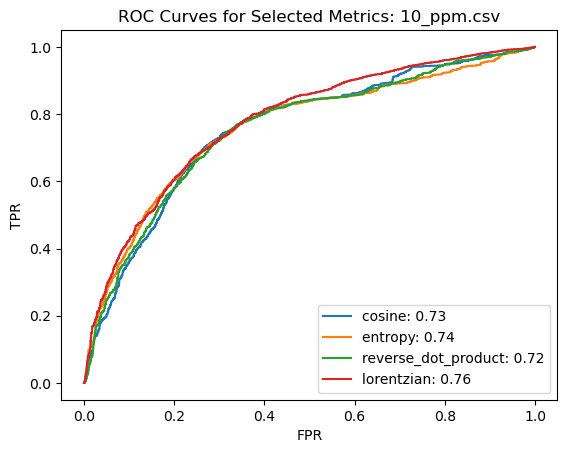

In [7]:
#first, generate tables from full size
reload(plotAndOrderResults)
reload(tests)
plotAndOrderResults.fig1(f'{outputs_path}/fig1',f'{outputs_path}/intermediateOutputs/fullSearchMatches')


In [8]:
#assess metric stability from small runs
reload(plotAndOrderResults)
plotAndOrderResults.fig2(f'{outputs_path}/fig2', ppm_windows)

Top Ranks and Means for 10 PPM: Metrics, 75 total
Proportion of Time This Metric is Top
                index    0
4          lorentzian  0.5
0           hellinger  0.2
1  max_bhattacharya_2  0.1
2             roberts  0.1
3            canberra  0.1


Mean Ranking By Metric
                   index     0
1             lorentzian   3.5
52    max_bhattacharya_2  14.9
50           max_entropy  15.4
13               entropy  20.1
18      lorentzian_jonah  22.9
31  max_lorentzian_jonah  23.3
16             cross_ent  25.2
54          max_matusita  25.3
55     max_squared_chord  25.7
19           max_roberts  26.2
30        max_braycurtis  26.3
29   max_manhattan_jonah  26.3
27            max_motyka  26.3
9                   chi2  26.3
28           max_ruzicka  26.4
22            braycurtis  26.5
11         entropy_jonah  26.6
5          jensenshannon  26.6
57    max_bhattacharya_1  26.6
21                motyka  26.7


Top Ranks and Means for 10 PPM: Vectorization Settings: 8 total
Proporti

Figure 3: Hierarchy of Metric Performance Conditional Distributions


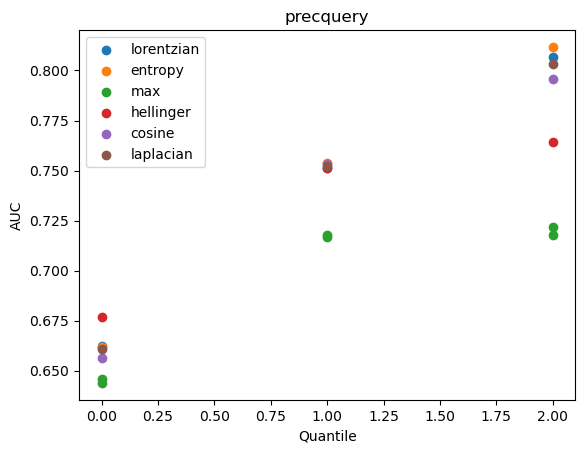

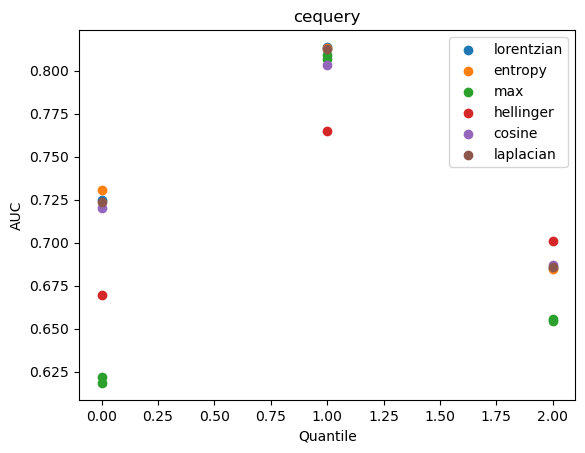

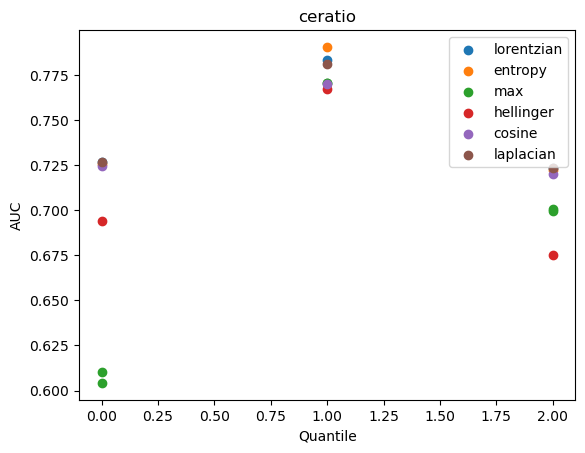

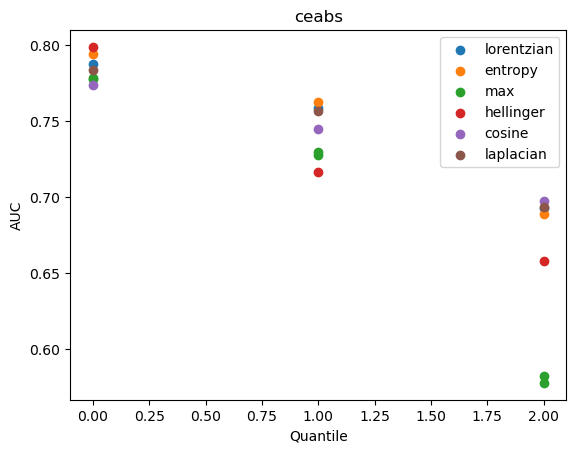

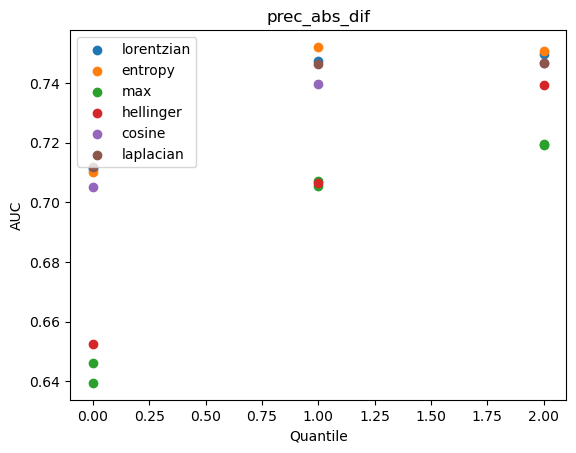

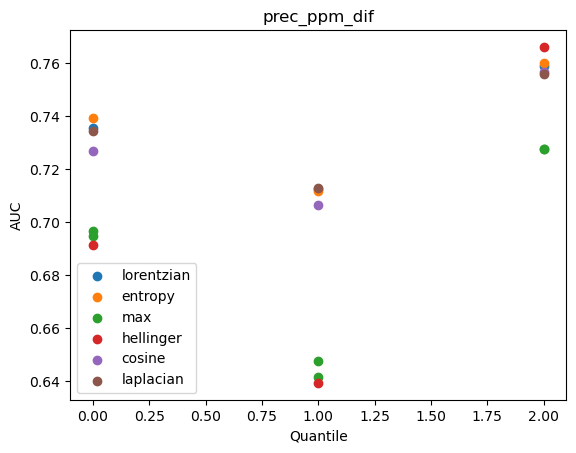

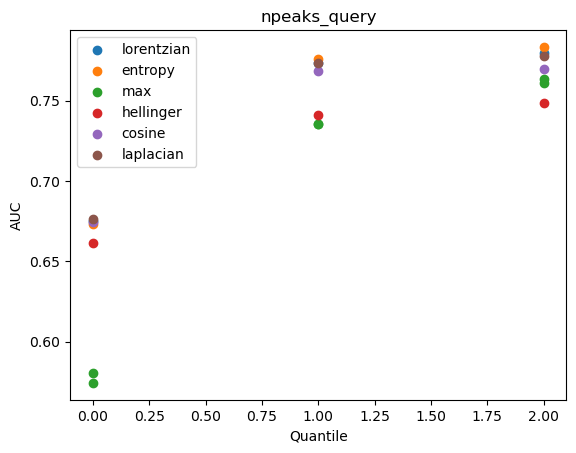

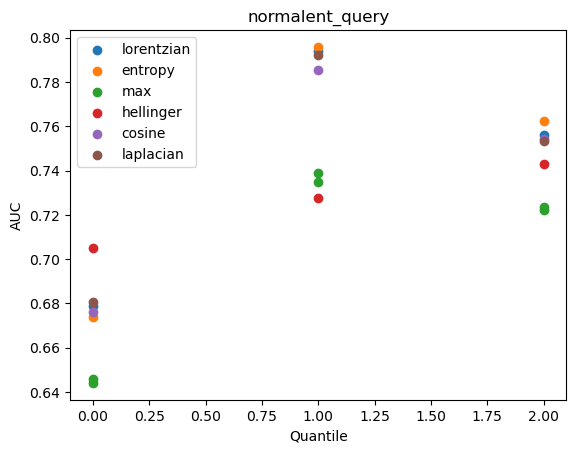

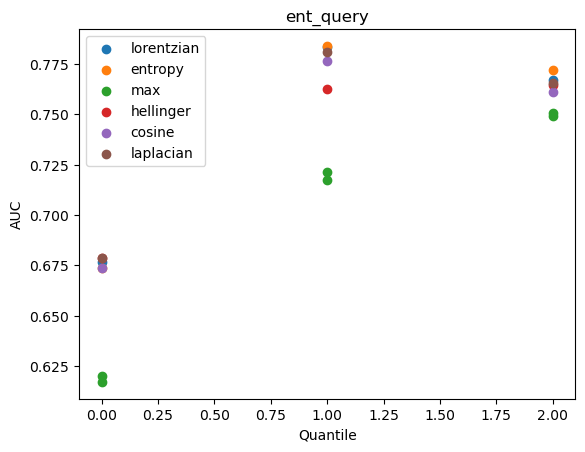

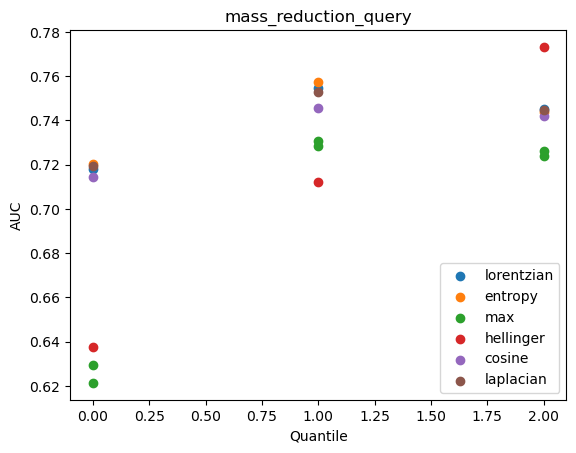

<Figure size 640x480 with 0 Axes>

In [9]:
#we will only consider the default weighting scheme here
#consider all the below metrics
reload(plotAndOrderResults)
reload(tests)
metrics=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2','cosine','laplacian']
quantile_variables = ['precquery', 'cequery','ceratio','ceabs', 'prec_abs_dif', 'prec_ppm_dif','npeaks_query','normalent_query','ent_query','mass_reduction_query']
quantile_num=3


for i in ppm_windows:

    matches = pd.read_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')
    input_data = datasetBuilder.create_model_dataset(matches,
                                                     sim_methods=metrics,
                                                     noise_threshes=[0.01],
                                                     centroid_tolerance_vals=[0.05],
                                                     centroid_tolerance_types=["da"],
                                                     powers=[1])

    metrics = input_data.columns[-len(metrics):-1]
    
    plotAndOrderResults.fig3(input_data, metrics, quantile_variables, quantile_num,f'{outputs_path}/fig3')

Figure 4: Combining Features Into Learned Model

First: Create Train and Test datasets for each ppm window

In [10]:
#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05,0.1]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da', 'da']
powers=[0.25,1,3,'ent',None]
sim_methods=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2']

train_size=1e4
val_size=2e3
test_size=5e3

max_matches=None

target_=pd.read_pickle(target)

for i in ppm_windows:

    #read in first bases and shuffle order
    query_train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    query_train=query_train.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_train,target_,i,max_matches,train_size, adduct_match)
    del(query_train)

    train = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )

    print(len(train))
    
    train.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
    del(matches)
    del(train)

    #read in first bases and shuffle order
    query_val = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    query_val=query_val.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_val,target_,i,max_matches,train_size, adduct_match)
    del(query_val)

    val = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )

    print(len(val))
    
    val.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/val_{i}_ppm.pkl')
    del(matches)
    del(val)

    #read in test queries and shuffle order
    query_test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    query_test=query_test.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_test,target_,i,max_matches,test_size, adduct_match)

    del(query_test)

    test = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )
    
    test.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
    matches.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm_matches.pkl')
    del(matches)
    del(test)

added 10 settings
added 20 settings
added 30 settings
10371
added 10 settings
added 20 settings
added 30 settings
10007
added 10 settings
added 20 settings
added 30 settings


Then, create the indices we want to test (different features for model)

In [11]:
reload(datasetBuilder)
indices=dict()

noise_threshes=[True,True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True,True]
spec_features=[True,True, True, True, True, True, True, True]#8
sim_methods=[True,True,True,True,True, True]#7

indices['all'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      True,
                                                      True
                                                    )

indices['all_but_nonspec'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      False,
                                                      True
                                                    )

indices['nonspec_only']=list(range(9))
indices['nonspec_no_ppm_info']=list(range(2,7))
indices['random_half']=list(np.random.choice(indices['all'][-1], size=int(indices['all'][-1]/2), replace=False))
indices['nonspec_no_precursor']=[2,3,4,5,6]


sim_methods=[False for i in range(6)]#7
indices['no_sims'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True
                                                    )

noise_threshes=[True,True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True,True]
spec_features=[False for i in range(8)]#8
sim_methods=[True for i in range(6)]#7

indices['sims_only'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      False,
                                                      False,
                                                    )


noise_threshes=[True,True,False]
centroid_tolerance_values=[True,True]
powers=[True,True,False,False,True]
spec_features=[True for i in range(8)]#8
sim_methods=[True,True,False,False,False, False]#7

indices['small_model'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True,
                                                    )

with open(f'{outputs_path}/intermediateOutputs/indices.pkl','wb') as path:
    pickle.dump(indices, path)

del(indices)
    



In [18]:
reload(plotAndOrderResults)
reload(tests)

indices = pickle.load(f'{outputs_path}/intermediateOutputs/indices.pkl')

for i in ppm_windows:
        #import train, val and test
        train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
        val = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/val_{i}_ppm.pkl')
        test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
        

        #hyperparam specifications for models, 
        #we will choose the best performer on val data for each feature subset
        models = [
                hgbc(),
                hgbc(learning_rate=0.01),
                hgbc(learning_rate=0.5),
                hgbc(max_iter=200),
                hgbc(learning_rate=0.01, max_iter=200),
                hgbc(learning_rate=0.5, max_iter=200),
                hgbc(min_samples_leaf=10),
                hgbc(learning_rate=0.01,min_samples_leaf=10),
                hgbc(learning_rate=0.5,min_samples_leaf=10),
                hgbc(max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.01, max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.5, max_iter=200,min_samples_leaf=10),
                ]

        results_by_subset = tests.best_models_by_subset(indices, [int(1e6)], models, train, val, test)

        del(train)
        del(val)
        del(test)

        with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl', 'wb') as models:

                pickle.dump(results_by_subset, models)

        del (results_by_subset)

TypeError: file must have 'read' and 'readline' attributes

Fig 4: Plot ROC Curves by Feature Subsets

AUROC by Feature Subset for 10 ppm:
random_half: 0.79
all: 0.79
small_model: 0.78
all_but_nonspec: 0.75
sims_only: 0.74
no_sims: 0.64
nonspec_only: 0.61
nonspec_no_precursor: 0.55
nonspec_no_ppm_info: 0.55
preds
[7.62606897e-05 7.82568494e-05 8.89963402e-05 8.92853904e-05
 9.54640916e-05]
trues
[0 0 0 0 0]
[0.99977132 0.99954265 0.99931397 0.9990853  0.99885662]
[1. 1. 1. 1. 1.]
preds
[0.07830115 0.07875527 0.07893831 0.07893831 0.07893831]
trues
[0 0 0 0 0]
[0.99977132 0.99954265 0.99931397 0.9990853  0.99885662]
[1. 1. 1. 1. 1.]
preds
[4.91664998e-05 4.91664998e-05 4.98008213e-05 4.98008213e-05
 4.99379276e-05]
trues
[0 0 0 0 0]
[0.99977132 0.99954265 0.99931397 0.9990853  0.99885662]
[1. 1. 1. 1. 1.]
preds
[0.02599939 0.02599939 0.02599939 0.02599939 0.02599939]
trues
[0 0 0 0 0]
[0.99977132 0.99954265 0.99931397 0.9990853  0.99885662]
[1. 1. 1. 1. 1.]
preds
[0.02632686 0.02632686 0.02632686 0.02632686 0.02648495]
trues
[0 0 0 0 0]
[0.99977132 0.99954265 0.99931397 0.9990853  0.9988

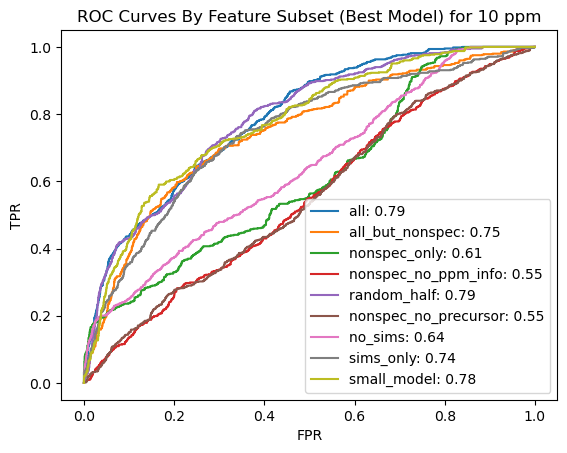

<Figure size 640x480 with 0 Axes>

In [ ]:
reload(plotAndOrderResults)
reload(tests)

for i in ppm_windows:

    test=pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')

    with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl','rb') as path:
        res_dict = pickle.load(path)

    with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
        indices = pickle.load(path)

    plotAndOrderResults.fig4(test, res_dict, indices, f'{outputs_path}/fig4', i)

Fig 5: Compare Performance on a Different Query Database

NameError: name 'output_path' is not defined

In [15]:
#set new query database
reload(plotAndOrderResults)
reload(tests)
new_query = gnps

noise_threshes=[0.01,0.05,0.1]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da', 'da']
powers=[0.25,1,3,'ent',None]
sim_methods=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2']

size=8e3
max_matches=None
adduct_match=False

for i in ppm_windows:
    
    new_query_ = pd.read_pickle(new_query)
    new_query_ = new_query_.sample(frac=1)
    target_ = pd.read_pickle(target)

    new_matches = datasetBuilder.create_matches_df_new(new_query_, target_,i ,max_matches,size,adduct_match)
    
    new_matches.to_pickle(f'{outputs_path}/fig5/matches_{i}_ppm.pkl')

    new_dataset = datasetBuilder.create_model_dataset(new_matches, 
                                                      sim_methods, 
                                                      noise_threshes, 
                                                      centroid_tolerance_vals, 
                                                      centroid_tolerance_types,
                                                      powers)
    
    with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
        indices = pickle.load(path)
        
    with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl','rb') as path:
        res_dict = pickle.load(path)

    plotAndOrderResults.fig5(new_dataset, res_dict, indices, f'{outputs_path}/fig5', i)

    #look at all individual metric ROCS
    individual_metrics=dict()
    for i in indices['sims_only']:

        individual_metrics[new_dataset.columns[i]]=list(i)

added 10 settings
added 20 settings
added 30 settings


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonahpoczobutt/projects/specsim_res/testy/intermediateOutputs/models/res_dict_10.pkl'

ksdjfklsjdlfksj
AUROC by Feature Subset for 10 ppm:
small_model: 0.77
all: 0.77
random_half: 0.75
sims_only: 0.74
all_but_nonspec: 0.74
no_sims: 0.68
nonspec_only: 0.56
nonspec_no_ppm_info: 0.47
nonspec_no_precursor: 0.46


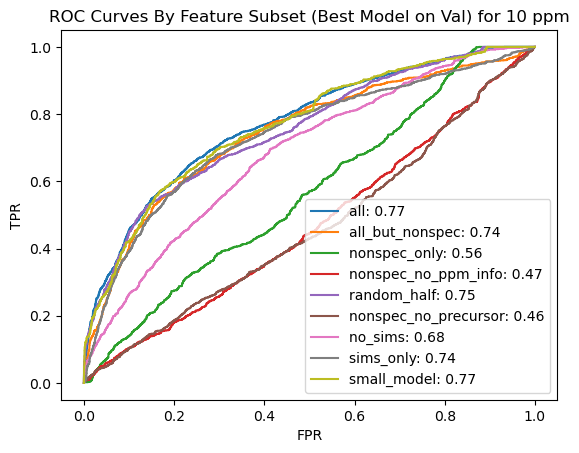

<Figure size 640x480 with 0 Axes>

In [ ]:
reload(plotAndOrderResults)
reload(tests)

plotAndOrderResults.fig5(new_dataset, res_dict, indices, f'{outputs_path}/fig5', 10)